# Supervised Learning (Part B)

## Set Up

**Mount Google Drive**

(Note: This cell is not required if working on an environment other than Google Colaboratory)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/MIST.6160.061/code

/content/drive/My Drive/Colab Notebooks/MIST.6160.061/code


**Ensure all relevant python libraries are installed using pip (package installer for Python)**

Some of these may already be installed, which is fine.

In [3]:
!pip install --upgrade pip
!pip install numpy
!pip install scipy
!pip install scikit-learn
!pip install matplotlib
!pip install pandas
!pip install pillow
!pip install imageio
!pip install joblib
!pip install graphviz
!pip install six

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.2.3)


Let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed as well as Scikit-Learn ≥0.20.

Typically, you can use this code as a template for other projects and can be updated by adding other libraries that you may need under the *Common imports* section. Also, you should modify the `SUB_DIR` variable to an appropriate name for the project you are working on.

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# to make this notebook's output identical/stable across runs
np.random.seed(7)

# set up numpy to display precision upto 3 decimal places and suppresses the use of scientific notation for small numbers
#np.set_printoptions(precision=3, suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Where to save the data and figures
PROJECT_ROOT_DIR = "."
IMAGES_DIR = "images"
DATA_DIR = "data"
SUB_DIR = "ch02-supervised-learning" # NOTE: update this for each project
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, IMAGES_DIR, SUB_DIR)
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, DATA_DIR, SUB_DIR)
os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs(DATA_PATH, exist_ok=True)

# Function for saving figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Function for saving data downloaded from a URL
from six.moves import urllib
def save_data(file_url, file_name):
    path = os.path.join(DATA_PATH, file_name)
    print("Saving data file", file_name)
    urllib.request.urlretrieve(file_url, path)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [5]:
from preamble import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Decision trees

Decision trees are a class of algorithms used for classification and regression in which the model is produced by **recursive partitioning** (splitting) of the data and takes the form of an upside-down tree (root above & branches/leaves below) which can also be expressed as a collection of if-then logical rules encoding the data partitioning using the predictors. 

Shown below is an example:

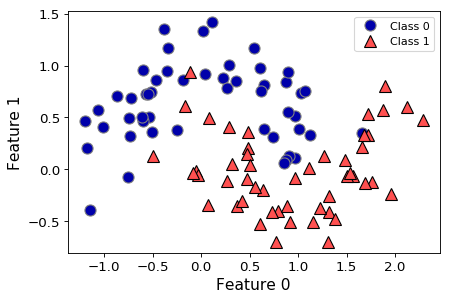

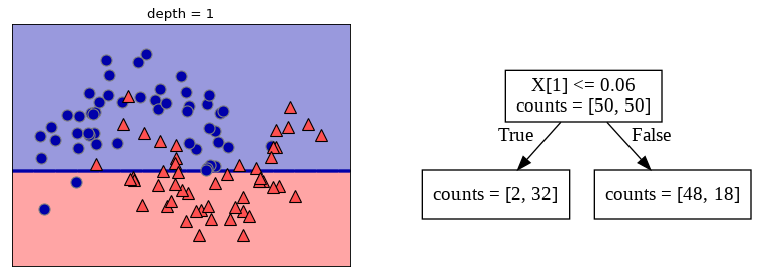

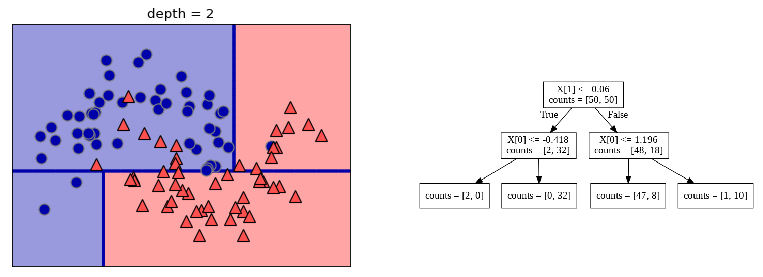

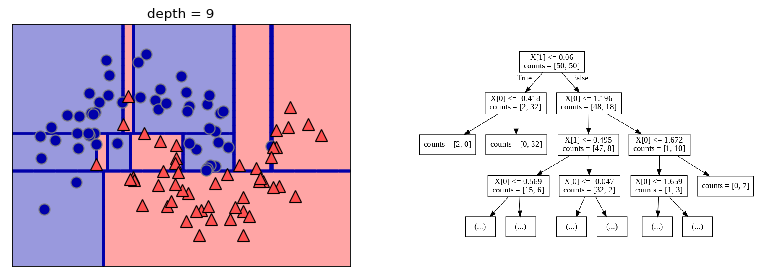

In [41]:
mglearn.plots.plot_tree_progressive()

### Loading cancer data

In [7]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
print("cancer.keys():\n", cancer.keys())

cancer.keys():
 dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [8]:
print("Shape of cancer data:", cancer.data.shape)

Shape of cancer data: (569, 30)


In [9]:
print("Sample counts per class:\n",
      {n: v for n, v in zip(cancer.target_names, np.bincount(cancer.target))})

Sample counts per class:
 {'malignant': 212, 'benign': 357}


In [10]:
print("Feature names:\n", cancer.feature_names)

Feature names:
 ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


### Building decision trees

> There are two common strategies to prevent overfitting: stopping the creation of the tree early (also called **pre-pruning**), or building the tree but then removing or collapsing nodes that contain little information (also called **post-pruning** or just **pruning**). Possible criteria for pre-pruning include limiting the maximum depth of the tree, limiting the maximum number of leaves, or requiring a minimum number of points in a node to keep splitting it. 

> Decision trees in `scikit-learn` are implemented in the `DecisionTreeRegressor` and `DecisionTreeClassifier` classes. **`scikit-learn` only implements pre-pruning, not post-pruning.**

In [11]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.937


> As expected, the accuracy on the training set is 100% — because the leaves arepure, the tree was grown deep enough that it could perfectlymemorize all the labels on the training data. The test set accuracy isslightly worse than for the linear models we looked at previously, which had around 95% accuracy.

### Controlling complexity of decision trees

> If we don’t restrict the depth of a decision tree, the tree can become arbitrarily deep and complex. Unpruned trees are therefore prone to overfitting and not generalizing well to new data. 

> Now let’s apply pre-pruning to the tree, which will stop developing the tree before we perfectly fit to the training data. One option is to stop building the tree after a certain depth has been reached. Here, we set `max_depth=4`, meaning only four consecutive questions can be asked. Limiting the depth of the tree decreases overfitting. This leads to a lower accuracy on the training set, but an improvement on the test set.

In [12]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.951


### Analyzing Decision Trees

> We can visualize the tree using the `export_graphviz` function from the tree module. This writes a file in the `.dot` file format, which is a text file format for storing graphs. 

> We set an option to color the nodes to reflect the majority class in each node and pass the class and features names so the tree can be properly labeled.

In [0]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"],
                feature_names=cancer.feature_names, impurity=False, filled=True)

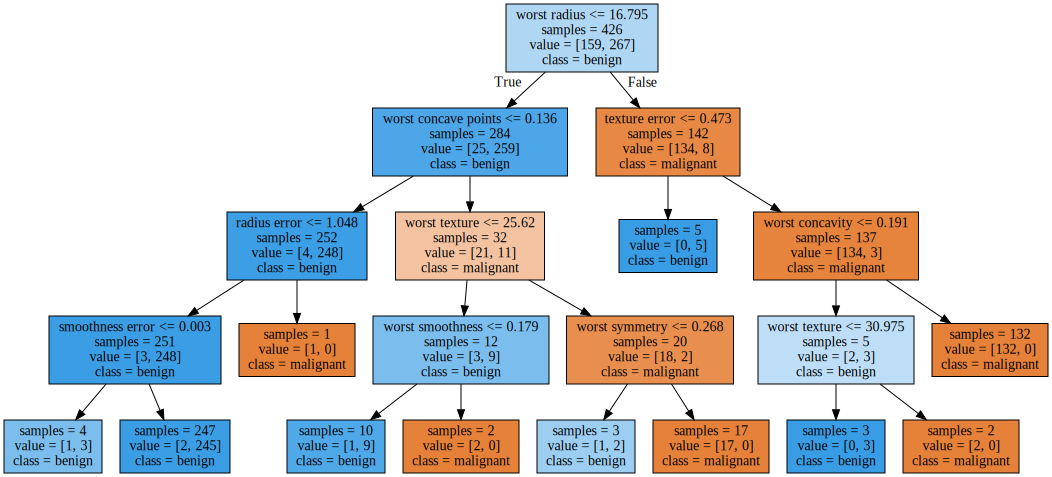

In [44]:
import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### Feature Importance in trees

> Instead of looking at the whole tree, which can be taxing, there are some useful properties that we can derive to summarize the workings of the tree. The most commonly used summary is **feature importance**, which rates how important each feature is for the decision a tree makes. It is a number between 0 and 1 for each feature, where 0 means "not used at all" and 1 means "perfectly predicts the target." The feature importances always sum to 1.

Couple of important points:

> - If a feature has a low value in `feature_importance_`, it doesn’t mean that this feature is uninformative. It only means that the feature was not picked by the tree, likely because another feature encodes the same information.

> - In contrast to the coefficients in linear models, feature importances are always positive, and don’t encode which class a feature is indicative of. In the following example, the feature importances tell us that "worst radius" is important, but not whether a high radius is indicative of a sample being benign or malignant.

In [0]:
print("Feature importances:")
print(tree.feature_importances_)

Feature importances:
[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.010 0.048
 0.000 0.000 0.002 0.000 0.000 0.000 0.000 0.000 0.727 0.046 0.000 0.000
 0.014 0.000 0.018 0.122 0.012 0.000]


In [0]:
print("Feature names:\n", cancer.feature_names)

Feature names:
 ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


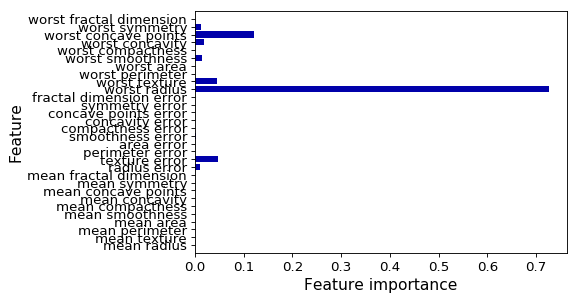

In [0]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances_cancer(tree)

### Decision Trees for Regression

> While we focused our discussion here on decision trees for classification, all that was said is similarly true for decision trees for regression, as implemented in `DecisionTreeRegressor`. The usage and analysis of regression trees is very similar to that of classification trees. There is one particular property of using tree-based models for regression that we want to point out, though. **The `DecisionTreeRegressor` (and all other tree-based regression models) is not able to extrapolate, or make predictions outside of the range of the training data.**

#### Loading example data

A dataset of historical computer memory (RAM) prices

In [0]:
# NOTE: Update this for each example
path = os.path.join(DATA_PATH, "ram_price.csv")

Text(0, 0.5, 'Price in $/Mbyte')

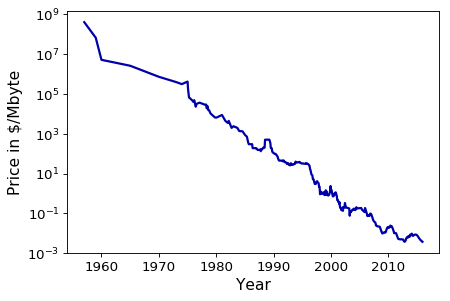

In [0]:
import os
ram_prices = pd.read_csv(path)

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte")

> Note the logarithmic scale of the y-axis. When plotting logarithmically, the relation seems to be quite linear and so should be relatively easy to predict, apart from some bumps.

> We will make a forecast for the years after 2000 using the historical data up to that point, with the date as our only feature. We will compare two simple models: a `DecisionTreeRegressor` and `LinearRegression`. We rescale the prices using a logarithm, so that the relationship is relatively linear. This doesn’t make a difference for the `DecisionTreeRegressor`, but it makes a big difference for `LinearRegression`.

#### Decision Tree Regressor

In [0]:
# use historical data to forecast prices after the year 2000
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# predict prices based on date
X_train = data_train.date[:, np.newaxis]
# we use a log-transform to get a simpler relationship of data to target
y_train = np.log(data_train.price)

from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth=3).fit(X_train, y_train)

from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression().fit(X_train, y_train)

# We make predictions on the whole dataset for visualization purposes here, 
# but for a quantitative evaluation we would only consider the test dataset:

# predict on all data
X_all = ram_prices.date[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

# undo log-transform
price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

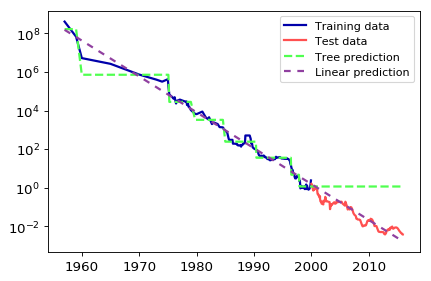

In [0]:
plt.semilogy(data_train.date, data_train.price, label="Training data")
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(ram_prices.date, price_tree, label="Tree prediction")
plt.semilogy(ram_prices.date, price_lr, label="Linear prediction")
plt.legend()

The difference between the models is quite striking. The linear model approximates the data with a line, as we knew it would. This line provides quite a good forecast for the test data (the years after 2000), while glossing over some of the finer variations in both the training and the test data. The tree model, on the other hand, makes perfect predictions on the training data; we did not restrict the complexity of the tree, so it learned the whole dataset by heart. However, once we leave the data range for which the model has data, the model simply keeps predicting the last known point. The tree has no ability to generate “new” responses, outside of what was seen in the training data. This shortcoming applies to all models based on trees.

#### Parameters
> As discussed earlier, the parameters that control model complexity in decision trees are the pre-pruning parameters that stop the building of the tree before it is fully developed. Usually, picking one of the pre-pruning strategies—setting either `max_depth`, `max_leaf_nodes`, or `min_samples_leaf` — is sufficient to prevent overfitting.

#### Strengths
> - The resulting model can easily be visualized and understood by nonexperts (at least for smaller trees).
> - The algorithms are completely invariant to scaling of the data. As each feature is processed separately, and the possible splits of the data don’t depend on scaling, no preprocessing like normalization or standardization of features is needed for decision tree algorithms. In particular, decision trees work well when you have features that are on completely different scales, or a mix of binary and continuous features.

#### Weaknesses
> - Even with the use ofpre-pruning, decision trees tend to overfit and provide poor generalization performance. Therefore, in most applications, the ensemble methods we discuss next are usually used in place of a single decision tree.

## Ensembles of Decision Trees

> Ensembles are methods that combine multiple machine learning models tocreate more powerful models. While there are many ensemble modeling methods, there are two ensemble models that have proven to be effective on a wide range ofdatasets for classification and regression, both of which use decision trees as their building blocks: **random forests** and **gradient boosted decision trees**.

### Random forests

> A main drawback of decision trees is that they tend to overfit the training data. Random forests are one way to address this problem. 

> A random forest is essentially a collection of decision trees, where each tree is slightly different from the others. The idea behind random forests is that each tree might do a relatively good job of predicting, but will likely overfit on part of the data. If we build many trees, all of which work well and overfit in different ways, we can reduce the amount of overfitting by averaging their results. This reduction in overfitting, while retaining the predictive power of the trees, can be shown using rigorous mathematics. 

> To implement this strategy, we need to build many decision trees. Each tree should do an acceptable job of predicting the target, and should also be different from the other trees. Random forests get their name from **injecting randomness into the tree building to ensure each tree is different**. 

> There are two ways in which the trees in a random forest are randomized: 
> - by selecting the data points used to build a tree and 
> - by selecting the features in each split test.

#### Building random forests

> To build a random forest model, you need to decide on the number of trees to build (the `n_estimators` parameter of `RandomForestRegressor` or `RandomForestClassifier`). 

> Let’s say we want to build 10 trees. These trees will be built completely independently from each other, and the algorithm will make different random choices for each tree to make surethe trees are distinct. 

> To build a tree, we first take what is called a **bootstrap sample** of our data. That is, from our `n_samples` data points, we repeatedly draw an example randomly with replacement (meaning the same sample can be picked multiple times),`n_samples` times. This will create a dataset that is as big as the original dataset, but some data points will be missing from it (approximately one third), and some will be repeated. To illustrate, let’s say we want to create a bootstrap sample of the list `['a', 'b', 'c', 'd']`. A possible bootstrap sample would be `['b', 'd', 'd', 'c']`. Another possible sample would be `['d', 'a', 'd', 'a']`.

> Next, a decision tree is built based on this newly created dataset. However, the algorithm we described for the decision tree is slightly modified. **Instead of looking for the best test for each node, in each node the algorithm randomly selects a subset of the features, and it looks for the best possible test involving one of these features**. The number of features that are selected is controlled by the `max_features` parameter. This selection of a subset of features is repeated separately in each node, so that each node in a tree can make a decision using a different subset of the features. 

> The bootstrap sampling leads to each decision tree in the random forest being built on a slightly different dataset. Because of the selection of features in each node, each split in each tree operates on a different subset of features. Together, these two mechanisms ensure that all the trees in the random forest are different. 

> A critical parameter in this process is `max_features`. If we set `max_features` to `n_features`, that means that each split can look at all features in the dataset, and no randomness will be injected in the feature selection (the randomness due to the bootstrapping remains, though). If we set `max_features` to 1, that means that the splits have no choice at all on which feature to test, and can only search over different thresholds for the feature that was selected randomly. Therefore, a high `max_features` means that the trees in the randomforest will be quite similar, and they will be able to fit the data easily, using the most distinctive features. A low `max_features` means that the trees in the random forest will be quite different, and that each tree might need to be very deep in order to fit the data well. 

> To make a prediction using the random forest, the algorithm first makes a prediction for every tree in the forest. For regression, we can average these results to get our final prediction. For classification, a "soft voting" strategy is used. This means each algorithm makes a "soft" prediction, providing a probability for each possible output label. The probabilities predicted by all the trees are averaged, and the class with the highest probability is predicted.

In [0]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.25, random_state=3)

In [0]:
X[:5,:]

array([[1.878, 0.568],
       [0.369, -0.349],
       [0.965, 0.109],
       [0.486, 0.203],
       [1.725, 0.534]])

In [0]:
y[:5]

array([1, 1, 0, 1, 1])

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    random_state=42)

from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

#### Analyzing random forests

The trees that are built as part of the random forest are stored in the `estimator_` attribute. We use this to visualize the trees in the random forest.

> Let’s visualize the decision boundaries learned by each tree, together with their aggregate prediction as made by the forest.

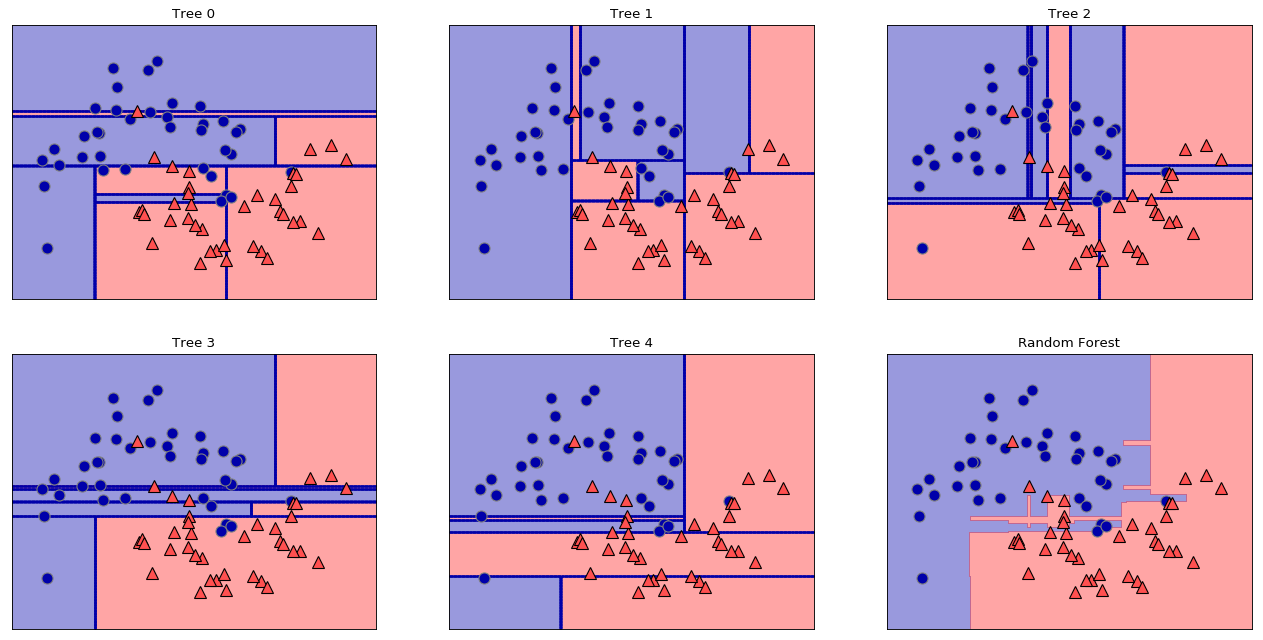

In [0]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1],
                                alpha=.4)
axes[-1, -1].set_title("Random Forest")
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

#### Another Example of Random Forests: Breast Cancer Dataset

In [0]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.972



> The random forest gives us an accuracy of 97%, better than the linear models or a single decision tree, without tuning any parameters. We could adjust the `max_features` setting, or apply pre-pruning as we did for the single decision tree. However, often the default parameters of the random forest already work quite well in this example.

> Similarly to the decision tree, the random forest provides feature importances, which are computed by aggregating the feature importances over the trees in the forest. Typically, the feature importances provided by the random forest are more reliable than the ones provided by a single tree.

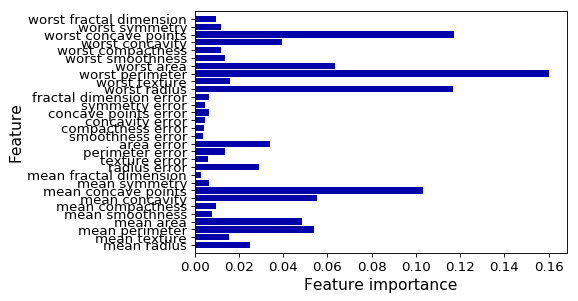

In [0]:
plot_feature_importances_cancer(forest)

#### Parameters
> - The important parameters to adjust are:  `n_estimators`, `max_features`, and possibly pre-pruning options like `max_depth`. 
> - For `n_estimators`, larger is always better. Averaging more trees will yield a more robust ensemble by reducing overfitting. However, there are diminishing returns, and more trees need more memory and more time to train. A common rule of thumb is to build “as many as you have time/memory for.”
> - `max_features` determines how random each tree is, and a smaller `max_features` reduces overfitting. In general, it’s a good rule of thumb to use the default values: `max_features=sqrt(n_features)` for classification and `max_features=n_features` for regression.
> - Adding `max_features` or `max_leaf_nodes` might sometimes improve performance. It can also drastically reduce space and time requirements for training and prediction.

#### Strengths
> - Very powerful, often work well without heavy tuning of the parameters
> - Don’t require scaling of the data
> - Share almost all the benefits of decision trees, while making up for some of their deficiencies.

#### Weaknesses

> - Interpretability: It is basically impossible to interpret tens or hundreds of trees in detail, and trees in random forests tend to be deeper than decision trees (because of the use of feature subsets). Therefore, if you need to summarize the prediction making in a visual way tononexperts, a single decision tree might be a better choice.
> - Computation: Building random forests on large datasets might be somewhat time consuming. However, if you are using a multi-core processor (as nearly all modern computers do), You can set `n_jobs=-1` to use all the cores in your computer for parallelizing.
> - Random forests, by their nature, are random, and setting different random states (or not setting the random_state at all) can drastically change the model that is built. The more trees there are in the forest, the more robust it will be against the choice of random state. If you want to have reproducible results, it is important to fix the random_state.
> - Random forests don’t tend to perform well on very high dimensional, sparse data, such as text data.


### Gradient Boosted Regression Trees (Gradient Boosting Machines) - GBT or GBM

> The gradient boosted regression tree is another ensemble method that combines multiple decision trees to create a more powerful model. Despite the “regression” in the name, **these models can be used for both regression and classification**. 

> In contrast to the random forest approach, gradient boosting works **by building trees in a serial manner, where each tree tries to correct the mistakes of the previous one**. By default, there is no randomization in gradient boosted regression trees; instead, **strong pre-pruning** is used. Gradient boosted trees (GBT) **often use very shallow trees**, of depth one to five, which makes the model smaller in terms of memory and makes predictions faster. The main idea behind gradient boosting is **to combine many simple models** (in this context known as **weak learners**), like shallow trees. Each tree can only provide good predictions on part of the data, and so more and more trees are added to iteratively improve performance.

> Apart from the pre-pruning and the number of trees in the ensemble, another important parameter of gradient boosting is the `learning_rate`, which controls how strongly each tree tries to correct the mistakes ofthe previous trees. A higher learning rate means each tree can make stronger corrections, allowing for more complex models. 

> Adding more trees to the ensemble, which can be accomplished by increasing `n_estimators`, also increases the model complexity, as the model has more chances to correct mistakes on the training set. 

> Here is an example of using `GradientBoostingClassifier` on the Breast Cancer dataset. By default, 100 trees of maximum depth 3 and a learning rate of 0.1 are used.

In [0]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.965


> As the training set accuracy is 100%, we are likely to be overfitting. To reduce overfitting, we could either apply stronger pre-pruning by limiting the maximum depth or lower the learning rate.

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.972


In [0]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.965


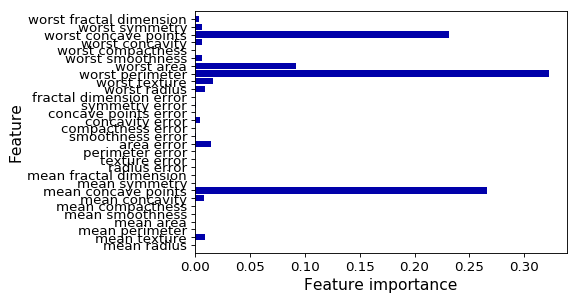

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plot_feature_importances_cancer(gbrt)

> We can see that the feature importances of the gradient boosted treesare somewhat similar to the feature importances of the random forests,though the gradient boosting completely ignored some of the features.

**Best Practice Tips**
> - As both gradient boosting and random forests perform well on similar kinds ofdata, a common approach is to **first try random forests, which work quite robustly**. If random forests work well but prediction time is at a premium, or it is important to squeeze out the last percentage of accuracy from the machine learning model, moving to gradient boosting often helps. 
> - If you want to apply gradient boosting to a large-scale problem, it might be worth looking into the [`xgboost`](https://xgboost.readthedocs.io/en/latest/#) package and its Python interface, which at the time of writing is faster (and sometimes easier to tune) than the `scikit-learn` implementation of gradient boosting on many datasets.

#### Parameters
> - The main parameters of gradient boosted tree models are the number of trees `n_estimators`, and the `learning_rate`, which controls the degree to which each tree is allowed to correct the mistakes of the previous trees. 
- These **two parameters are highly interconnected**, as **a lower `learning_rate` means that more trees are needed to build a model of similar complexity**. In contrast to random forests, where a higher `n_estimators` value is always better, **increasing `n_estimators` in gradient boosting leads to a more complex model**, which may lead to overfitting. 
- A common practice is to fit `n_estimators` depending on the time and memory budget, and then search over different `learning_rates`. 
- Another important parameter is `max_depth` (or alternatively `max_leaf_nodes`), to reduce the complexity of each tree. Usually `max_depth` is set very low for gradient boosted models, often not deeper than five splits.

#### Strengths
> - Among the most powerful and widely used models for supervised learning. 
> - The algorithm works well without scaling and on a mixture of binary and continuous features. 
> - Share almost all the benefits of decision trees, while making up for some of their deficiencies.

#### Weaknesses
> - They require careful tuning of the parameters and may take a long time to train.
> - As with other tree-based models, it also often does not work well on high-dimensional sparse data.



## Kernelized Support Vector Machines

> Kernelized support vector machines (often just referred to as SVMs are an extension of linear support vector machines that allows for more complex models that are not defined simply by hyperplanes in the input space. 

> While there are support vector machines for classification and regression, we will restrict ourselves to the classification case, as implemented in `SVC`. Similar concepts apply to support vector regression, as implemented in `SVR`.



### Linear Models and Non-linear Features

> - Linear models can be quite limiting in low-dimensional spaces, as lines and hyperplanes have limited flexibility. 
> - One way to make a linear model more flexible is by adding more features — for example, by adding interactions or polynomials of the input features.

#### Example with a synthetic dataset

Text(0, 0.5, 'Feature 1')

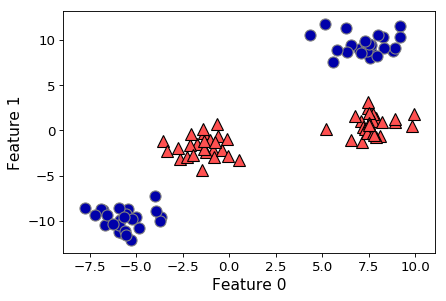

In [0]:
from sklearn.datasets import make_blobs
X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

> A linear model for classification can only separate points using a line, and will not be able to do a very good job on this dataset, as shown below.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0, 0.5, 'Feature 1')

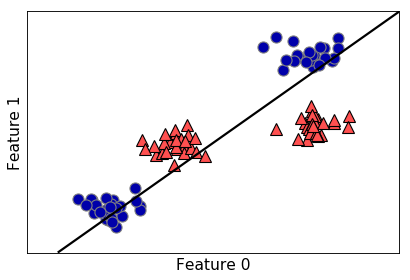

In [0]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

> Now let’s expand the set of input features, say by also adding `feature1 ** 2`, the square of the second feature, as a new feature. Instead of representing each data point as a two-dimensional point, `(feature0, feature1)`, we now represent it as a three-dimensional point, `(feature0, feature1, feature1 ** 2)`.

Text(0.5, 0, 'feature1 ** 2')

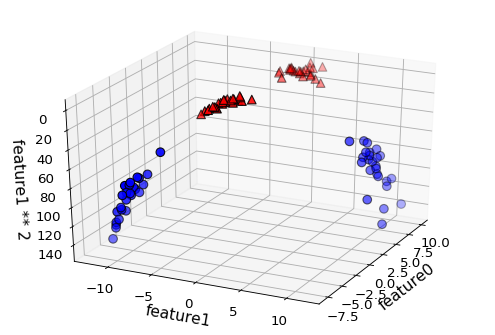

In [0]:
# add the squared first feature
X_new = np.hstack([X, X[:, 1:] ** 2])


from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()
# visualize in 3D
ax = Axes3D(figure, elev=-152, azim=-26)
# plot first all the points with y==0, then all with y == 1
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")

> In the new representation of the data, it is now indeed possible to separate the two classes using a linear model, a plane in three dimensions. 

> We can confirm this by fitting a linear model to the augmented data.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0.5, 0, 'feature1 ** 2')

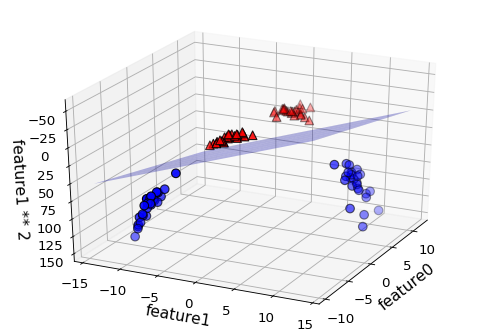

In [0]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# show linear decision boundary
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')

ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")

> As a function of the original features, the linear SVM model is not actually linear anymore. It is not a line, but more of an ellipse, as you can see from the plot created below.

Text(0, 0.5, 'Feature 1')

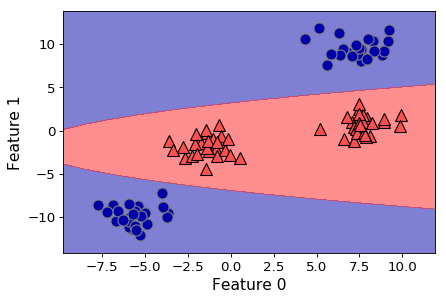

In [0]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

#### The Kernel Trick

> There is a clever mathematicaltrick that allows us to learn a classifier in a higher-dimensional space without actually computing the new, possibly very large representation. This is known as the **kernel trick**, and it works by directly computing the distance (more precisely, the scalar products) of the datapoints for the expanded feature representation, without ever actually computing the expansion.

> There are two ways to map your data into a higher-dimensional space thata re commonly used with support vector machines: 
> 1. The **polynomial kernel**, which computes all possible polynomials up to a certain degree of the original features (like `feature1 ** 2 * feature2 ** 5`); and 
> 2. The radial basis function (RBF) kernel, also known as the **Gaussian kernel**. The Gaussian kernel is a bit harder to explain, as it corresponds to an infinite-dimensional feature space. One way to explain the Gaussian kernel is that it considers all possible polynomials of all degrees, but theimportance of the features decreases for higher degrees.

#### Understanding SVMs
> - During training, the SVM learns how important each of the training datapoints is to represent the decision boundary between the two classes. 
> - Typically only a subset of the training points matter for defining thedecision boundary: the ones that lie on the border between the classes. These are called **support vectors** and give the support vector machineits name. 
> - To make a prediction for a new point, the distance to each of the supportvectors is measured. 
> - A classification decision is made based on the distances to the support vector, and the importance of the support vectors that was learned during training (stored in the `dual_coef_` attribute of SVC).

> Example below shows the result of training a support vector machine on a two-dimensional two-class dataset. The decision boundary is shown in black, and the support vectors are larger points with the wide outline.

Text(0, 0.5, 'Feature 1')

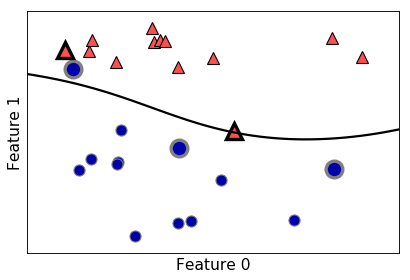

In [0]:
from sklearn.svm import SVC

X, y = mglearn.tools.make_handcrafted_dataset()                                                                  
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
# plot support vectors
sv = svm.support_vectors_
# class labels of support vectors are given by the sign of the dual coefficients
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

#### Tuning SVM parameters

> - The **`gamma`** parameter corresponds to the inverse of the width of the Gaussian kernel. Intuitively, the gamma parameter determines how far the influence of a single training example reaches, with **low values meaning corresponding to a far reach,and high values to a limited reach**. In other words, the wider the radius of the Gaussian kernel, the further the influence of each training example. 
> - **A low value of gamma means that the decision boundary will vary slowly, which yields a model of low complexity, while a high value of gamma yields a more complex model.**

> - The **`C`** parameter is a regularization parameter, similar to that used in thelinear models. It limits the importance of each point (or more precisely, their `dual_coef_`).
> - As with the linear models, **a small C means a very restricted model**, where each data point can only have very limited influence. **Increasing C allows these points to have a stronger influence on the model** and makes the decision boundary bend to correctly classify them.

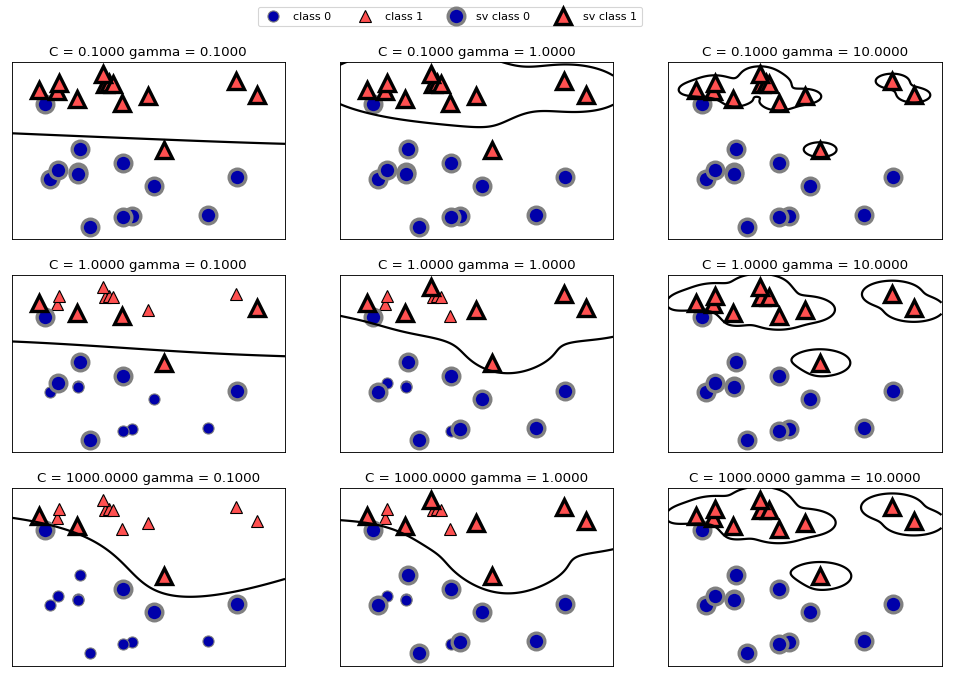

In [0]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)
        
axes[0, 0].legend(["class 0", "class 1", "sv class 0", "sv class 1"],
                  ncol=4, loc=(.9, 1.2))

#### Another Example of SVM: Breast Cancer Dataset

**Note**: By default, `C=1` and `gamma=1/n_features`

In [13]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.63


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


> The model overfits quite substantially, with a perfect score on the training set and only 63% accuracy on the test set. 

> While SVMs often perform quite well, they are very sensitive to the settings of the parameters and to the scaling of the data. In particular, they require all the features to vary on a similar scale. 

> Let’s look at the minimum and maximum values for each feature, plotted in log-space.

Text(0, 0.5, 'Feature magnitude')

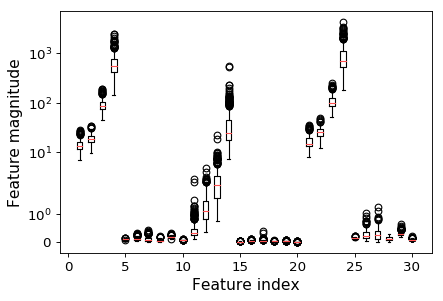

In [16]:
plt.boxplot(X_train, manage_xticks=False)
plt.yscale("symlog")
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")

#### Preprocessing data for SVMs (Example: Cancer Dataset)

In [22]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = minmax_scaler.fit_transform(X_train)
X_test_scaled = minmax_scaler.transform(X_test)  # use THE SAME transformation on the test set, do NOT fit it on the test set again.

print("Minimum for each feature\n", X_train_scaled.min(axis=0))
print("Maximum for each feature\n", X_train_scaled.max(axis=0))

Minimum for each feature
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000]
Maximum for each feature
 [1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000
 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000
 1.000 1.000 1.000 1.000 1.000 1.000]


In [23]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(
        svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.948
Accuracy on test set: 0.951


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [24]:
from sklearn.svm import SVC
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(
    svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.972


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


**Observation**: Increasing C allows us to improve the model significantly, resulting in 97.2% accuracy

#### Parameters
> - The important parameters in kernel SVMs are the regularization parameter `C`, the choice of the kernel, and the kernel-specific parameters. Although we primarily focused on the RBF kernel, other choices are available in `scikit-learn`. 
> - The RBF kernel has only one parameter, `gamma`, which is the inverse of the width of the Gaussian kernel. `gamma` and `C` both control the complexity of the model, **with large values in either resulting in a more complex model**. Therefore, **good settings for the two parameters are usually strongly correlated, and `C` and `gamma` should be adjusted together**.

#### Strengths
> - Kernelized support vector machines are powerful models and perform well on a variety of datasets. 
> - SVMs allow for complex decision boundaries, even if the data has only a few features. 
> - They work well on low-dimensional and high-dimensional data (i.e., few and many features).

#### Weaknesses
> - Kernelized SVMs don’t scale very well with the number of samples. Running an SVM on data with up to 10,000 samples might work well, but working with datasets of size 100,000 or more can become challenging in terms of runtime and memory usage.
> - They require careful preprocessing of the data and tuning of the parameters. This is why, these days, most people instead use tree-based models such as random forests or gradient boosting (which require little or no preprocessing) in many applications. (Still, it might be worth trying SVMs, particularly if all of your features represent measurements in similar units (e.g., all are pixel intensities) and they are on similar scales.)
> - Furthermore, SVM models are hard to inspect; it can be difficult to understand why a particular prediction was made, and it might be tricky to explain the model to a nonexpert.


## Uncertainty Estimates from Classifiers

> - Often, you are not only interested in which class aclassifier predicts for a certain test point, but also how certain it is that this is the right class. 
> - There are two different functions in `scikit-learn` that can be used to obtain uncertainty estimates from classifiers: `decision_function` and `predict_proba`. Most (but not all) classifiers have at least one of them, and many classifiers have both.

Example: Let’s look at what these two functions do on a synthetic two-dimensional dataset, when building a `GradientBoostingClassifier` classifier, which has both a `decision_function` and a `predict_proba` method:

In [25]:
from sklearn.datasets import make_circles
X, y = make_circles(noise=0.25, factor=0.5, random_state=1)

# we rename the classes "blue" and "red" for illustration purposes:
y_named = np.array(["blue", "red"])[y]

# we can call train_test_split with arbitrarily many arrays;
# all will be split in a consistent manner
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_named, y_test_named, y_train, y_test = \
    train_test_split(X, y_named, y, random_state=0)

# build the gradient boosting model
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train_named)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### The Decision Function

> - In the binary classification case, the return value of `decision_function` is of shape `(n_samples,)`, and it returns one floating-point number for each sample.
> - This value encodes how strongly the model believes a data point to belong to the “positive” class, in this case class 1. Positive values indicate a preference for the positive class, and negative values indicate a preference for the “negative” (other) class:

In [26]:
print("X_test.shape:", X_test.shape)
print("Decision function shape:",
      gbrt.decision_function(X_test).shape)

X_test.shape: (25, 2)
Decision function shape: (25,)


In [27]:
# show the first few entries of decision_function
print("Decision function:", gbrt.decision_function(X_test)[:6])

Decision function: [4.136 -1.702 -3.951 -3.626 4.290 3.662]


> - We can recover the prediction by looking only at the sign of the decision function:

In [28]:
print("Thresholded decision function:\n",
      gbrt.decision_function(X_test) > 0)
print("Predictions:\n", gbrt.predict(X_test))

Thresholded decision function:
 [ True False False False  True  True False  True  True  True False  True
  True False  True False False False  True  True  True  True  True False
 False]
Predictions:
 ['red' 'blue' 'blue' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue'
 'red' 'red' 'blue' 'red' 'blue' 'blue' 'blue' 'red' 'red' 'red' 'red'
 'red' 'blue' 'blue']


> For binary classification, the “negative” class is always the first entry of the `classes_` attribute, and the “positive” class is the second entry of `classes_`. So if you want to fully recover the output of predict, you need to make use of the `classes_` attribute:

In [30]:
gbrt.classes_

array(['blue', 'red'], dtype='<U4')

> - The range of `decision_function` can be arbitrary, and depends on the data and the model parameters.
> - This arbitrary scaling makes the output of `decision_function` often hard to interpret.

In [31]:
decision_function = gbrt.decision_function(X_test)
print("Decision function minimum: {:.2f} maximum: {:.2f}".format(
      np.min(decision_function), np.max(decision_function)))

Decision function minimum: -7.69 maximum: 4.29


### Predicting Probabilities

> - The output of `predict_proba` is a probability for each class.
> - It is often more easily understood than the output of `decision_function`.
> - It is always of shape `(n_samples, 2)` for binary classification.

In [32]:
print("Shape of probabilities:", gbrt.predict_proba(X_test).shape)

Shape of probabilities: (25, 2)


> - The first entry in each row is the estimated probability of the first class, and the second entry is the estimated probability of the second class. 
> - Because it is a probability, the output of `predict_proba` is always between 0 and 1, and the sum of the entries for both classes is always 1.

In [33]:
# show the first few entries of predict_proba
print("Predicted probabilities:")
print(gbrt.predict_proba(X_test[:6]))

Predicted probabilities:
[[0.016 0.984]
 [0.846 0.154]
 [0.981 0.019]
 [0.974 0.026]
 [0.014 0.986]
 [0.025 0.975]]


> - You can see in the previous output that the classifier is relatively certain for most points. How well the uncertainty actually reflects uncertainty in the data depends on the model and the parameters. 
> - A model that is more overfitted tends to make more certain predictions, even if they might be wrong. 
> - A model with less complexity usually has more uncertainty in its predictions.
> - A model is called calibrated if the reported uncertainty actually matches how correct it is — in a calibrated model, a prediction made with 70% certainty would be correct 70% of the time.

> The [`scikit-learn`](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) website has a great comparison of many models and what their uncertainty estimates look like. Check it out.

![classifier_comparison](https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png)

### Uncertainty in multiclass classification

> The `decision_function` and `predict_proba` methods also work in the multiclass setting. 

Let’s apply them on the Iris dataset, which is a three-class classification dataset:

In [34]:
from sklearn.datasets import load_iris
iris = load_iris()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=42)

from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(learning_rate=0.01, random_state=0)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [35]:
print("Decision function shape:", gbrt.decision_function(X_test).shape)
# plot the first few entries of the decision function
print("Decision function:")
print(gbrt.decision_function(X_test)[:6, :])

Decision function shape: (38, 3)
Decision function:
[[-1.996 0.048 -1.927]
 [0.061 -1.908 -1.928]
 [-1.991 -1.876 0.097]
 [-1.996 0.048 -1.927]
 [-1.997 -0.135 -1.203]
 [0.061 -1.908 -1.928]]


> In the multiclass case, the `decision_function` has the shape `(n_samples, n_classes)` and each column provides a “certainty score” for each class, where a large score means that a class is more likely and a small score means the class is less likely. You can recover the predictions from these scores by finding the maximum entry for each datapoint:

In [36]:
print("Argmax of decision function:")
print(np.argmax(gbrt.decision_function(X_test), axis=1))
print("Predictions:")
print(gbrt.predict(X_test))

Argmax of decision function:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


In [37]:
# show the first few entries of predict_proba
print("Predicted probabilities:")
print(gbrt.predict_proba(X_test)[:6])
# show that sums across rows are one
print("Sums:", gbrt.predict_proba(X_test)[:6].sum(axis=1))

Predicted probabilities:
[[0.102 0.788 0.109]
 [0.783 0.109 0.107]
 [0.098 0.110 0.792]
 [0.102 0.788 0.109]
 [0.104 0.667 0.229]
 [0.783 0.109 0.107]]
Sums: [1.000 1.000 1.000 1.000 1.000 1.000]


> We can again recover the predictions by computing the argmax of `predict_proba`.

In [38]:
print("Argmax of predicted probabilities:")
print(np.argmax(gbrt.predict_proba(X_test), axis=1))
print("Predictions:")
print(gbrt.predict(X_test))

Argmax of predicted probabilities:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


> - To summarize, `predict_proba` and `decision_function` always have shape `(n_samples, n_classes)` — apart from `decision_function` in the special binary case. 
> - In the binary case, `decision_function` only has one column, corresponding to the “positive” class `classes_[1]`.

> You can recover the prediction when there are `n_classes` many columns by computing the argmax across columns. Be careful, though, if your classes are strings, or you use integers but they are not consecutive and starting from 0. If you want to compare results obtained with `predict` to results obtained via `decision_function` or `predict_proba`, make sure to use the `classes_` attribute of the classifier to get the actual class names.

In [40]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

# represent each target by its class name in the iris dataset
named_target = iris.target_names[y_train]
logreg.fit(X_train, named_target)

print("unique classes in training data:", logreg.classes_)
print("predictions:", logreg.predict(X_test)[:10])

argmax_dec_func = np.argmax(logreg.decision_function(X_test), axis=1)
print("argmax of decision function:", argmax_dec_func[:10])
print("argmax combined with classes_:",
      logreg.classes_[argmax_dec_func][:10])

unique classes in training data: ['setosa' 'versicolor' 'virginica']
predictions: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']
argmax of decision function: [1 0 2 1 1 0 1 2 1 1]
argmax combined with classes_: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
